In [10]:
from azureml.core import Workspace

ws = Workspace.from_config()

In [12]:
# View available compute targets
display(ws.compute_targets.keys())
# View current workspace
display(ws.name)

dict_keys(['DS-Associate-Computer', 'DS-Ass-Cluster'])

'ML-2s-sandbox'

In [135]:
# Import libraries + data + data peek
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline 

data = pd.read_csv('data/diabetes.csv')
data.head(2)

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0


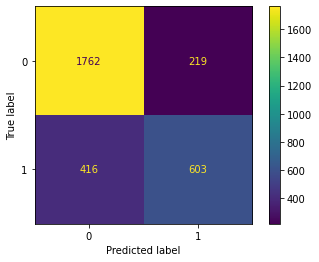

In [82]:
from azureml.core import Experiment
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

# Create an experiment
experiment = Experiment(workspace = ws, name='logreg-experiment')
# Start logging
run = experiment.start_logging()

data = pd.read_csv('data/diabetes.csv')
X = data.drop(columns=['PatientID', 'Diabetic'])
y = data.iloc[:,-1]

# Scale X
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2)

# Number of rows in data for funsies
run.log('observations', len(data))
run.log('positives', len(data[data['Diabetic'] == 1]))
run.log('negatives', len(data[data['Diabetic'] == 0]))

# Train a model
model = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

auc = roc_auc_score(y_test, y_pred)
run.log('AUC', auc)

conf = plot_confusion_matrix(model, X_test, y_test)
run.log_image(name = "confusion_matrix", plot = plt)

# Upload sample file, because why not
sample = data.sample(n=100)
sample.to_csv('sample.csv')
run.upload_file(name='outputs/sample.csv', path_or_stream='sample.csv')

run.complete()

In [90]:
# Verify data was saved
display(run.get_file_names())
display(run.get_metrics())

['confusion_matrix_1605713666.png', 'outputs/sample.csv']

{'observations': 15000,
 'positives': 5000,
 'negatives': 10000,
 'AUC': 0.740603198491657,
 'confusion_matrix': 'aml://artifactId/ExperimentRun/dcid.0c785956-2020-4213-9eae-fb06d547dcae/confusion_matrix_1605713666.png'}

In [91]:
run.get_details()

{'runId': '0c785956-2020-4213-9eae-fb06d547dcae',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2020-11-18T15:34:24.51503Z',
 'endTimeUtc': '2020-11-18T15:34:34.035642Z',
 'properties': {'azureml.git.repository_uri': 'https://github.com/rnymke/ml_notebooks.git',
  'mlflow.source.git.repoURL': 'https://github.com/rnymke/ml_notebooks.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '8af96ae52bd6c42d317ab31b4d725835ec37e29b',
  'mlflow.source.git.commit': '8af96ae52bd6c42d317ab31b4d725835ec37e29b',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': '3a3bc399-7396-48c5-b602-f44072f79dcd'},
 'inputDatasets': [],
 'outputDatasets': [],
 'logFiles': {}}

### Script, scriptarguments, model registration, estimator
Similar experiment is run but is instead sent to the cluster using the Estimator class, the model is saved and later registered and there is now an input argument (-reg--rate) that is submitted to the script.

In [92]:
folder_name = 'experiment_script'

In [122]:
%%writefile $folder_name/diabetes_experiment.py
from azureml.core import Run
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

parser = argparse.ArgumentParser()
parser.add_argument('--reg_rate', type=float, dest='reg', default=0.01)
args = parser.parse_args()
reg = args.reg

# Start logging
run = Run.get_context()

data = pd.read_csv('data/diabetes.csv')
X = data.drop(columns=['PatientID', 'Diabetic'])
y = data.iloc[:,-1]

# Scale X
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2)

# Number of rows in data for funsies
run.log('observations', len(data))
run.log('positives', len(data[data['Diabetic'] == 1]))
run.log('negatives', len(data[data['Diabetic'] == 0]))

# Train a model
model = LogisticRegression(C=1/reg, random_state=0).fit(X_train, y_train)
y_pred = model.predict(X_test)

auc = roc_auc_score(y_test, y_pred)
run.log('AUC', auc)

conf = plot_confusion_matrix(model, X_test, y_test)
run.log_image(name = "confusion_matrix", plot = plt)

# Upload sample file, because why not
sample = data.sample(n=100)
# Creates outputs folder which is auto-uploaded to the experiment, instead of run.upload_file()
sample.to_csv('outputs/sample.csv')
# Save model
joblib.dump(value=model, filename='outputs/model.pkl')

run.complete()

Overwriting experiment_script/diabetes_experiment.py


In [123]:
from azureml.core import Experiment
from azureml.train.estimator import Estimator

estimator = Estimator(source_directory=folder_name,
                      entry_script='diabetes_experiment.py',
                      compute_target='DS-Ass-Cluster',
                      conda_packages=['scikit-learn', 'matplotlib'],
                      script_params = {'--reg_rate': 0.1}
                    )
experiment = Experiment(workspace = ws, name='diabetes_experiment_script')
run = experiment.submit(config=estimator)
run.wait_for_completion(show_output=True)

RunId: diabetes_experiment_script_1605777196_c6e6f4bf
Web View: https://ml.azure.com/experiments/diabetes_experiment_script/runs/diabetes_experiment_script_1605777196_c6e6f4bf?wsid=/subscriptions/08265842-251e-450c-8d28-a06ee3f3c611/resourcegroups/DataSandbox/workspaces/ML-2s-sandbox

Streaming azureml-logs/75_job_post-tvmps_097495fbe9b25d12a01240313bb37ab0377efcebe01c264f5806e17659584638_d.txt

[2020-11-19T09:19:15.686804] Entering job release
[2020-11-19T09:19:16.686524] Starting job release
[2020-11-19T09:19:16.691683] Logging experiment finalizing status in history service.
[2020-11-19T09:19:16.691940] job release stage : upload_datastore starting...
Starting the daemon thread to refresh tokens in background for process with pid = 153
[2020-11-19T09:19:16.692381] job release stage : start importing azureml.history._tracking in run_history_release.
[2020-11-19T09:19:16.692416] job release stage : execute_job_release starting...
[2020-11-19T09:19:16.703267] job release stage : copy_b

{'runId': 'diabetes_experiment_script_1605777196_c6e6f4bf',
 'target': 'DS-Ass-Cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-11-19T09:18:55.281876Z',
 'endTimeUtc': '2020-11-19T09:19:24.889189Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'e61b4ccd-f8e2-4451-af07-ec0e2dce5b12',
  'azureml.git.repository_uri': 'https://github.com/rnymke/ml_notebooks.git',
  'mlflow.source.git.repoURL': 'https://github.com/rnymke/ml_notebooks.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '8af96ae52bd6c42d317ab31b4d725835ec37e29b',
  'mlflow.source.git.commit': '8af96ae52bd6c42d317ab31b4d725835ec37e29b',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'useAbsolutePath': False,
  'arguments': ['--reg_ra

In [111]:
run.get_metrics()
run.get_details()

{'runId': 'diabetes_experiment_script_1605716593_a519dc4b',
 'target': 'DS-Ass-Cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-11-18T16:23:27.988116Z',
 'endTimeUtc': '2020-11-18T16:24:02.438435Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': 'ed5179ad-628f-41be-80dd-13eeb1abe9ef',
  'azureml.git.repository_uri': 'https://github.com/rnymke/ml_notebooks.git',
  'mlflow.source.git.repoURL': 'https://github.com/rnymke/ml_notebooks.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '8af96ae52bd6c42d317ab31b4d725835ec37e29b',
  'mlflow.source.git.commit': '8af96ae52bd6c42d317ab31b4d725835ec37e29b',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'script': 'diabetes_experiment.py',
  'useAbsolutePath': False,
  'arguments': [],
  'sou

In [124]:
from azureml.core import Model
# Having saved the model, let's register it
run.register_model( model_name='diabetes_logreg',
                    model_path='outputs/model.pkl', # run outputs path
                    description='A classification model',
                    tags={'a_tag': 'tag_value'},
                    model_framework=Model.Framework.SCIKITLEARN)


Model(workspace=Workspace.create(name='ML-2s-sandbox', subscription_id='08265842-251e-450c-8d28-a06ee3f3c611', resource_group='DataSandbox'), name=diabetes_logreg, id=diabetes_logreg:1, version=1, tags={'a_tag': 'tag_value'}, properties={})

In [128]:
for model in Model.list(ws):
    print(model.name, model.version)

diabetes_logreg 1
diabetes_model 6
diabetes_model 5
diabetes_model 4
diabetes_model 3
diabetes_model 2
diabetes_model 1
AutoML25c938d120 1
